# Mixtures of Gaussian processes with GPclust


This notebook accompanies the paper

**Nonparameteric Clustering of Structured Time Series**  
_James Hensman, Magnus Rattray and Neil D. Lawrence_  
IEEE TPAMI 2014

The code is available at <https://github.com/jameshensman/gpclust> . The GPclust module depends on [GPy](https://github.com/SheffieldML/GPy).  

The hierachical Gaussian process model was fleshed out in 

**Hierarchical Bayesian modelling of gene expression time series  
across irregularly sampled replicates and clusters**  
_James Hensman, Neil D. Lawrence and Magnus Rattray_

http://www.biomedcentral.com/1471-2105/14/252

A simple implementation of hierarchical GPs is available as part of GPy. You may also be interested in the related notebook on hierarchical GPs.


In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'#'svg' would be better, but eats memory for these big plots.
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as n
import GPclust
import GPflow

## A simple sinusoid dataset

Here's a simulated dataset that contains the simple features that we expect to have in real data sets: smooth processes (here, sinusoids) corrupted by further smooth processes (here, more sinusoids) as well as noise. 

In [28]:
#generate a data set. Here's the sinusoid demo from the manuscript.
Nclust = 10
Nx = 12
Nobs = [np.random.randint(20,31) for i in range(Nclust)] #a random number of realisations in each cluster
X = np.random.rand(Nx,1)
X.sort(0)

#random frequency and phase for each cluster
base_freqs = 2*np.pi + 0.3*(np.random.rand(Nclust)-.5)
base_phases = 2*np.pi*np.random.rand(Nclust)
means = np.vstack([np.tile(np.sin(f*X+p).T,(Ni,1)) for f,p,Ni in zip(base_freqs,base_phases,Nobs)])

#add a lower frequency sinusoid for the noise
freqs = .4*np.pi + 0.01*(np.random.rand(means.shape[0])-.5)
phases = 2*np.pi*np.random.rand(means.shape[0])
offsets = 0.3*np.vstack([np.sin(f*X+p).T for f,p in zip(freqs,phases)])
Y = means + offsets + np.random.randn(*means.shape)*0.05

In the plot below, we show the underlying function for each cluster as a smooth red function, and the data associated with the cluster as thinly connected blue crosses. 

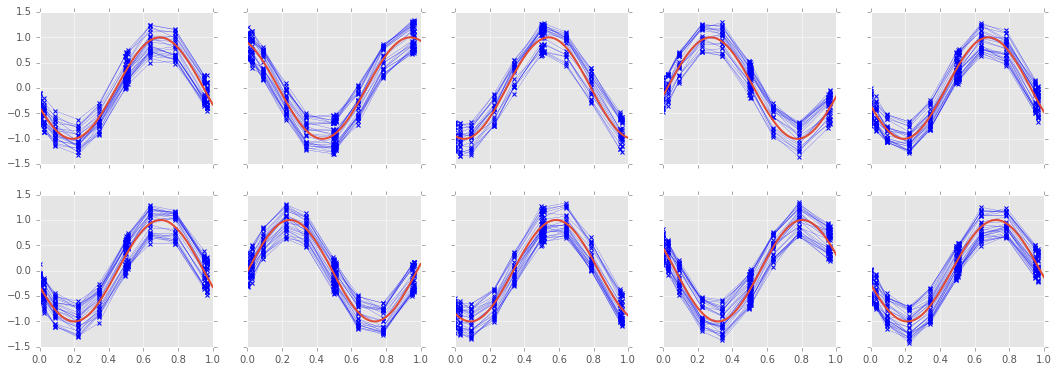

In [29]:
#plotting. 
x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
f, axes = plt.subplots(2, Nclust//2, figsize=(18,6), sharex=True, sharey=True)
index_starts = np.hstack([0, np.cumsum(Nobs[:-1])])
index_stops = np.cumsum(Nobs)
for n, ax in enumerate(axes.flatten()):
    ax.plot(X, Y[index_starts[n]:index_stops[n]].T, 'b', marker='x',ms=4, mew=1, linewidth=0.2)
    ax.plot(x_plot, np.sin(base_freqs[n]*x_plot+base_phases[n]), linewidth=2)
    

Constructing and optimizing a model
---

Now that we have generated a data set, it's straightforward to build and optimize a clustering model. First, we need to build two GPy kernels (covariance functions), which will be used to model the underlying function and the replication noise, respecively. We'll take a wild stab at the parameters of these covariances, and let the model optimize them for us later. 

The two kernels model the *underlying* function of the cluster, and the deviations of each gene from that underlying function. If we believe that the only corruption of the data from the cluster mean is i.i.d. noise, we can specify a `GPy.kern.White` covariance. In practise, it's helpful to allow correlated noise. The model of any cluster of genes then has a hierarchical structure, with the unknown cluster-specific mean drawn from a GP, and then each gene in that cluster being drawn from a GP with said unknown mean function. 

To optimize the model with the default optimization settings, we call m.optimize(). To invoke the recommended merge-split procedure, call m.systematic_splits(). Note that during the splitting procedure, many calls are made to the optimize function. 

In [30]:
k_underlying = GPflow.kernels.RBF(input_dim=1, variance=0.1, lengthscales=0.1)
k_corruption = GPflow.kernels.RBF(input_dim=1, variance=0.01, lengthscales=0.1) + GPflow.kernels.White(1, variance=0.001)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, num_clusters=10, prior_Z='symmetric', alpha=1.0)
m.optimize()
# m.systematic_splits(verbose=False)

iteration 1 bound=-2352.11560538 grad=13800.7760588, beta=0
iteration 2 bound=1085.39042367 grad=224301.83183, beta=1.15095576772
iteration 3 bound=1334.53299333 grad=952.478655441, beta=0.0
iteration 4 bound=1452.39333684 grad=151.923583282, beta=0.422555639562
iteration 5 bound=1461.40264829 grad=16.9190579011, beta=0.0
iteration 6 bound=1469.07427397 grad=6.79921615534, beta=0.0
iteration 7 bound=1488.87678863 grad=14.838853889, beta=2.02878424192
iteration 8 bound=1499.08705628 grad=8.78869151586, beta=0.0
iteration 9 bound=1512.64944188 grad=13.6542241033, beta=1.30229351598
iteration 10 bound=1517.72146925 grad=7.70981695864, beta=0.0
iteration 11 bound=1520.06938413 grad=3.20176303964, beta=0.054712908806
iteration 12 bound=1520.83333543 grad=0.999016275359, beta=0.274222990924
iteration 13 bound=1520.97274267 grad=0.131851482797, beta=0.183775449409
iteration 14 bound=1521.02495197 grad=0.0409571236571, beta=0.300047729146
iteration 15 bound=1521.05351204 grad=0.0197047992442, 

Plotting and examining the posterior
---
The model has quite extensive plotting built in, with various options for colour, display of the data as points or connected lines, etc. Here we find that the model manages to separate all but two of the true clusters. The number of 'genes' found in each cluster is labeled in the corner of each plot. 

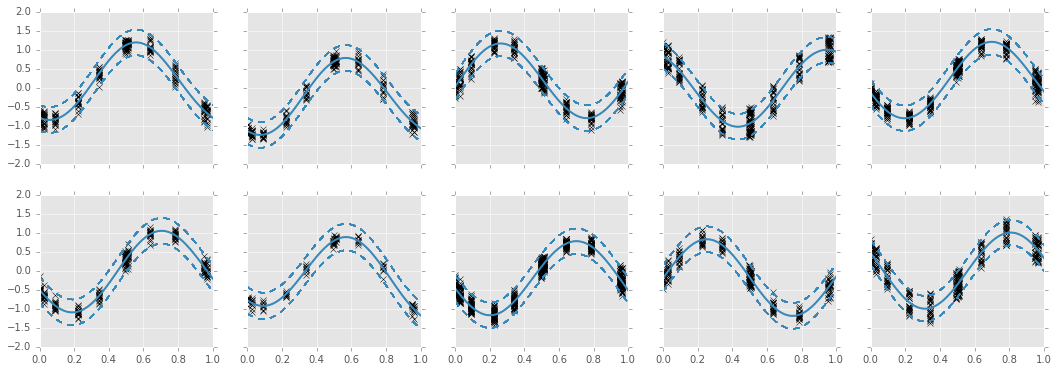

In [36]:

#plt.matshow(m.get_phi())
#m.plot(on_subplots=True, colour=True, newfig=False)
x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
f, axes = plt.subplots(2, Nclust//2, figsize=(18,6), sharex=True, sharey=True)
mu, var = m.predict_components(x_plot)
phi = m.get_phi()
for i, (mu_i, var_i, ax), in enumerate(zip(mu, var, axes.flatten())):
    # ax.plot(x_plot[:,0], 2*np.diag(var_i))
    #ax.imshow(var_i, interpolation='nearest')
    ax.plot(x_plot[:,0], mu_i)
       
    ind = np.argmax(phi, 1) == i
    if np.any(ind):
        ax.plot(X, Y[ind, :].T, 'kx')
    line, = ax.plot(x_plot[:,0], mu_i, lw=2)
    ax.plot(x_plot[:,0], mu_i + 2*np.sqrt(np.diag(var_i)), '--', lw=1, color=line.get_color())
    ax.plot(x_plot[:,0], mu_i - 2*np.sqrt(np.diag(var_i)), '--', lw=1, color=line.get_color())

Structure is important
---
Why do we have to specify two kernels in GPclust? The first kernel describes the properties of the functions which underly each cluster. The second describes the properties of the functions which describe how each time-course (gene) deviates from the cluster. 

This structure is important: if we model the deviation of each time-course from the cluster as simply noise, it's more difficult to infer the correct clusters. Such a model can be constructed in GPclust by using a white (noise) kernel for the structure, as follows.


In [18]:
#exactly as above, but with a white-noise kernel for the structure.
k_underlying = GPflow.kernels.RBF(input_dim=1, variance=0.1, lengthscales=0.1)
k_corruption = GPflow.kernels.White(1, variance=0.1)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, num_clusters=10, prior_Z='symmetric', alpha=1.0)
m.optimize()
m.systematic_splits(verbose=False)

iteration 1 bound=-2608.37289339 grad=1531.53134921, beta=0
iteration 2 bound=-990.795036302 grad=30958.0094179, beta=2.15678239699
iteration 3 bound=-769.036615933 grad=231.072180417, beta=0.0
iteration 4 bound=-706.42242059 grad=132.934980884, beta=0.0
iteration 5 bound=-693.091122988 grad=15.7607610573, beta=0.085856745464
iteration 6 bound=-685.17956862 grad=7.03013453644, beta=0.174471532969
iteration 7 bound=-675.018953907 grad=7.98893460932, beta=0.0
iteration 8 bound=-658.905833152 grad=17.9245030751, beta=1.88386785215
iteration 9 bound=-657.537833498 grad=1.8825415508, beta=0.0
iteration 10 bound=-656.7252074 grad=0.673995543912, beta=0.295982130843
iteration 11 bound=-656.190507594 grad=0.553672414187, beta=0.0
iteration 12 bound=-655.699959732 grad=0.519816872422, beta=0.0
iteration 13 bound=-655.040857565 grad=0.430316207788, beta=0.821182344955
iteration 14 bound=-654.659299933 grad=0.203478214354, beta=0.559531060599
iteration 15 bound=-654.475463638 grad=0.08605935942, 

AttributeError: 'MOHGP' object has no attribute 'phi'

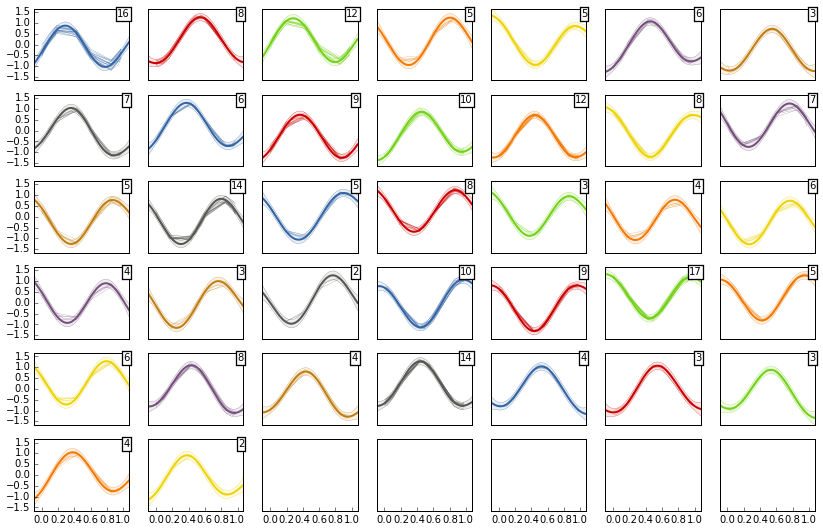

In [11]:
plt.figure(figsize=(14,9))
m.plot(on_subplots=True, colour=True, newfig=False)

Here we can see that the procedure finds too many clusters (we know that the ground truth is that there are 10). This is because without the ability to model the deviation from the cluster mean in a structured fashion, that structure appears as additional clusters. 

This point is exaggerated a little by the toy data that we have generated, but the same issue exists in real data. For more details and consideration of the cluster structure, see the subsequent notebook on clustering Drosophila development. 